<a href="https://colab.research.google.com/github/IronmanBD/LeNet-5-Implementation/blob/main/GoogleNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget "https://s3.amazonaws.com/video.udacity-data.com/topher/2018/September/5baa60a0_flower-photos/flower-photos.zip"

--2020-12-20 16:43:14--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/September/5baa60a0_flower-photos/flower-photos.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.108.61
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.108.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 229734282 (219M) [application/zip]
Saving to: ‘flower-photos.zip’

flower-photos.zip   100%[===================>] 219.09M  56.9MB/s    in 4.2s    

2020-12-20 16:43:18 (52.6 MB/s) - ‘flower-photos.zip’ saved [229734282/229734282]



In [2]:
!unzip -qq flower-photos.zip

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as Optimizer
import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt

In [4]:
transform = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224), 
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
batch_size = 32
data_dir = 'flower_photos'

traindata = datasets.ImageFolder(data_dir + '/train', transform=transform)
testdata  = datasets.ImageFolder(data_dir + '/test', transform=transform)

trainloader = torch.utils.data.DataLoader(traindata, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testdata, batch_size=batch_size, shuffle=True)

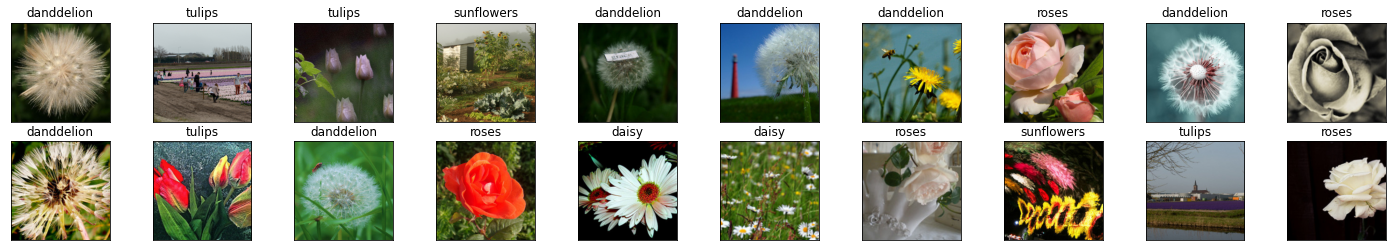

In [5]:
classes = ['daisy','danddelion', 'roses', 'sunflowers', 'tulips']
def imshow(img):
   img = img / 2 + 0.5  # unnormalize
   plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

dataiter = iter(trainloader)
images, labels = dataiter.next()
images = images.numpy()

fig = plt.figure(figsize=(25,4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
  imshow(images[idx])
  ax.set_title(classes[labels[idx]])

In [6]:
class ConvBlock(nn.Module):
  def __init__(self, in_channels, out_channels, **kwargs):
    super(ConvBlock, self).__init__()
    self.relu = nn.ReLU()
    self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
    self.batchnorm = nn.BatchNorm2d(out_channels)

  def forward(self,x):
    return self.relu(self.batchnorm(self.conv(x)))

In [15]:
class InceptionBlock(nn.Module):
  def __init__(self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool):
    super(InceptionBlock, self).__init__()

    self.branch1 = ConvBlock(in_channels, out_1x1, kernel_size=1)

    self.branch2 = nn.Sequential(
        ConvBlock(in_channels, red_3x3, kernel_size=1),
        ConvBlock(red_3x3, out_3x3, kernel_size=3, stride=1, padding=1)
    )
    self.branch3 = nn.Sequential(
        ConvBlock(in_channels, red_5x5, kernel_size=(1,1)),
        ConvBlock(red_5x5, out_5x5, kernel_size=(5,5), padding=(2,2))
    )
    self.branch4 = nn.Sequential(
        nn.MaxPool2d(kernel_size = 3, stride = 1, padding=1),
        ConvBlock(in_channels, out_1x1pool, kernel_size=1)
    )

  def forward(self,x):
    y1 = self.branch1(x)
    y2 = self.branch2(x)
    y3 = self.branch3(x)
    y4 = self.branch4(x)
    return torch.cat([y1,y2,y3,y4], 1)


In [16]:
class GoogleNet(nn.Module):
    def __init__(self, aux_logits=True, num_classes=6):
        super(GoogleNet, self).__init__()
        assert aux_logits == True or aux_logits == False
        self.aux_logits = aux_logits

        self.conv1 = ConvBlock(
            in_channels=3,
            out_channels=64,
            kernel_size=(7, 7),
            stride=(2, 2),
            padding=(3, 3)
        )

        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = ConvBlock(64, 192, kernel_size=3, stride=1, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # In this order: in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool
        self.inception3a = InceptionBlock(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = InceptionBlock(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(kernel_size=(3, 3), stride=2, padding=1)

        self.inception4a = InceptionBlock(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = InceptionBlock(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = InceptionBlock(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = InceptionBlock(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = InceptionBlock(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception5a = InceptionBlock(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = InceptionBlock(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AvgPool2d(kernel_size=7, stride=1)
        self.dropout = nn.Dropout(p=0.4)
        self.fc1 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)

        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)

        x = self.inception4a(x)


        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)

        x = self.inception4e(x)
        x = self.maxpool4(x)
        x = self.inception5a(x)
        x = self.inception5b(x)
        x = self.avgpool(x)
        x = x.view(x.shape[0],-1)
        x = self.dropout(x)
        x = self.fc1(x)

        return x

        

In [9]:
class InceptionAux(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(InceptionAux, self).__init__()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.7)
        self.pool = nn.AvgPool2d(kernel_size=5, stride=3)
        self.conv = ConvBlock(in_channels, 128, kernel_size=1)
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.pool(x)
        x = self.conv(x)
        x = x.view(x.shape[0],-1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [17]:
model = GoogleNet(aux_logits=True, num_classes=6)
criterion = nn.CrossEntropyLoss()
optimizer = Optimizer.SGD(model.parameters(), lr=0.001)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.cuda()

GoogleNet(
  (conv1): ConvBlock(
    (relu): ReLU()
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv2): ConvBlock(
    (relu): ReLU()
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (inception3a): InceptionBlock(
    (branch1): ConvBlock(
      (relu): ReLU()
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (branch2): Sequential(
      (0): ConvBlock(
        (relu): ReLU()
        (conv): Conv2d(192, 96, kernel_size=(1, 

In [19]:
# number of epochs to train the model
n_epochs = 10  # suggest training between 20-50 epochs
train_losses=[]
for epoch in range(n_epochs):
    train_loss = 0.0

    for images, labels in trainloader:
        # clear the gradients of all optimized variables
        images=images.to(device)
        labels=labels.to(device)
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model.forward(images)
        # calculate the loss
        loss = criterion(output,labels)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
        
    # print training statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(trainloader.dataset)
    train_losses.append(train_loss)
    if epoch%2==0: 
      print('Epoch: {} \tTraining Loss: {:.6f}'.format(
          epoch, 
          train_loss
          ))

Epoch: 0 	Training Loss: 1.592038
Epoch: 2 	Training Loss: 1.122081
Epoch: 4 	Training Loss: 0.917930
Epoch: 6 	Training Loss: 0.802587
Epoch: 8 	Training Loss: 0.704658


In [20]:
test_loss = 0.
correct = 0.
total = 0.

model.eval()
for batch_idx, (data, target) in enumerate(testloader):
        data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
        
        print('test batch {}, loss {:.6f}'.format(batch_idx, test_loss), end='\r')
            
print('Test Loss: {:.6f}\n'.format(test_loss))

print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

Test Loss: 0.722638


Test Accuracy: 72% (389/540)
